In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq
import Pyro4.util

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


C:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.amprabi_opt_ctrl_state_prep
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.crosstalk_echo_calib
imp

In [4]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [5]:
expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
# expt_path = 'C:\_Data\LLqub'
print('Data will be stored in', expt_path)

Data will be stored in S:\Connie\experiments\qramLL_4QR2\data\data_240617


In [6]:
config_file = 'config_q3diamond_full688and638_reset.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_zcu216.yml'
# config_file = 'config_zcu216_LLStdCandle.yml'
config_path = os.path.join(os.getcwd(), config_file)
print('Config will be', config_path)

Config will be S:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and638_reset.yml


# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [7]:
import yaml
print('Using config file', config_file)
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

Using config file config_q3diamond_full688and638_reset.yml


In [8]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium
# print(im)
print(im.keys())

dict_keys(['Pyro.NameServer', 'Qick60', 'Heman', 'NeonFilament', 'qdac', 'Qick187', 'SC_26C1', 'SC_2FF1', 'YOKO4', 'RS'])


In [9]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Mon Jul 24 13:57:32 2023):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.08

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
# lo1 = SignalCore(name="SignalCore", address='10003494')
lo1.open_device()
print(lo1.get_id())

# TURN OFF
lo1.set_standby(True)
lo1.set_output_state(False)

# print(lo1.get_device_status().pll_status.crs_pll_ld)

# # TURN ON
# lo1.set_standby(False)
# lo1.set_output_state(True)
# # lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
# # lo_power = float(yaml_cfg.hw.lo.readout.power)
# lo_freq = 4385.5e6
# lo_power = 14
# lo1.set_frequency(lo_freq) # Set LO frequency
# print(f'set lo freq to {lo_freq*1e-6} MHz')
# lo1.set_power(lo_power) # Set LO power
# print(f'set lo power to {lo_power} dBm')

# Single qubit RB

In [ ]:
qubit_i = 2
# qubits = [2, 1]
# qubit_i = qubits[0]

In [ ]:
rbprog = meas.SimultaneousRBExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb1Q_qubit{qubit_i}",
    config_file=config_path,
)

gate_char = None
# gate_char = 'X'

# max_gates = 225

max_gates = 100
# expts = 30
expts = 5

if gate_char is None: step = max_gates // expts
else: step = max_gates // (2*expts)
print('step', step)


rbprog.cfg.expt = dict(
    # start=1, # rb depth start
    start=34, # rb depth start
    step=step, # step rb depth
    # step=5, # step rb depth
    # expts=expts, # number steps
    expts=1, # number steps
    reps=50000000, # number averages per unique sequence
    variations=3, # number different sequences per depth
    gate_char=None, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=[qubit_i], # the qubits to perform simultaneous RB on (if eg-gf, q should be qA != 1)
    # qubits=qubits,
    # qDrive=qubits[0],
    # singleshot_reps=20000, # reps per state for singleshot calibration
    singleshot_reps=100, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    # thresholds=[0, 613.9114184246247, 507.47891189954305, 0],
    # angles=[0, -101.54512016437148, 72.02480620589141, 0],
    # ge_avgs=[array([0., 0., 0., 0.]), [-101.85060937209302, 466.51286116279067, -154.72153951162792, 742.5887439767441], [21.863250678241997, -256.37994772110693, 120.73579574064026, -794.2915984536081], array([0., 0., 0., 0.])],
    # counts_calib=[[16238, 3110, 527, 125], [3374, 16034, 95, 497], [1968, 395, 14344, 3293], [494, 2404, 2838, 14264]]
)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
rbprog.analyze(fit=True)
rbprog.display(fit=True, qubit=[qubit_i])

In [ ]:
p_irb = 0.913
p_rb = 0.949  
print(100*meas.fitting.rb_error(p_rb, 2),'% average error')
print(100*(1-meas.fitting.rb_gate_fidelity(p_rb, p_irb, 2)), '% gate error')

In [ ]:
qDrive = qubits[0]
setup_ZZ = 0

In [ ]:
rbprog.save_data()

### EF RB

In [123]:
qubit_i = 2

step 10
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.95193842109995, 5794.90833333, 501.288233333334, -229.94910723], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.37577390000007], 'gain': [0.25, 0.3, 0.85, 0.35], 'readout_length': [8.0, 10.0, 7.0, 6.0], 'readout_length_ef': [8.0, 7.0, 4.0, 4.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4110.428247950795, 3448.2234633901926, 4762.201572322125, 4381.680438663265], 'f_ef': [3884.3737933985267, 3347.761789059698, 4572.387578885567, 4209.9856996522185], 'f_Q1_ZZ': [3442.837979505655, 0, 3447.102664818869, 3446.9016438865956], 'f_Q_ZZ1': [4105.061776980227, 0, 4761.0850337068905, 4380.355943299591], 'f_ef_Q_ZZ1': [0, 0, 4570.466450039196, 4207.199191279], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q': [0, 0, 5883.96, 5147.14], 'f_f0g1': [1184.4, 999.8, 1632.9833333333333, 1620.9166666666665], 'gs': [52.40296404695958, 54.81794

  0%|          | 0/3 [00:00<?, ?it/s]

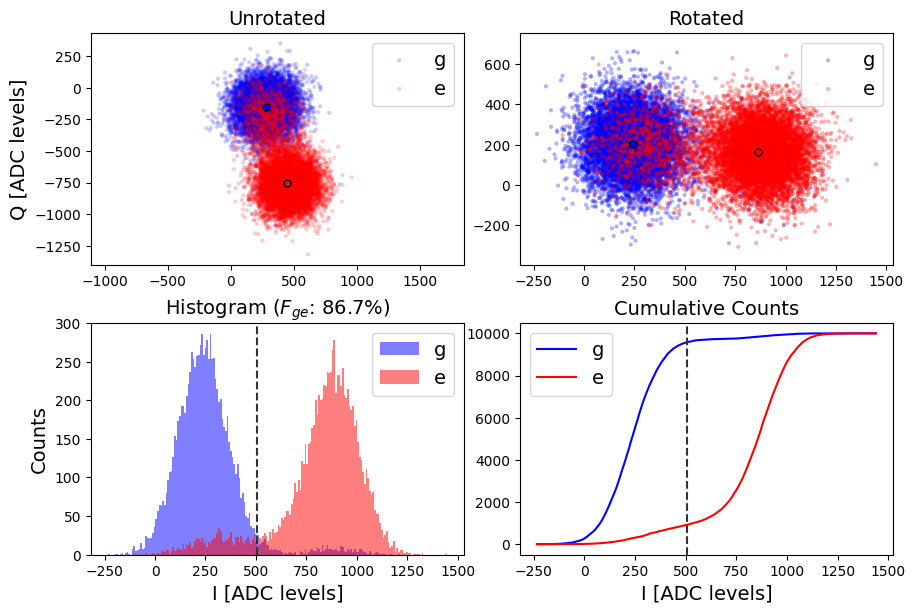

thresholds=[0, 0, 506.37205463267946, 0],
angles=[0, 0, 69.27266084341585, 0],
ge_avgs=[[0, 0, 0, 0], [0, 0, 0, 0], [280.94884079069766, -169.03692613953487, 443.6283454883721, -712.7931671162792], [0, 0, 0, 0]] ,
thresholds=[0, 0, 506.37205463267946, 0],
angles=[0, 0, 69.27266084341585, 0],
ge_avgs=[[0, 0, 0, 0], [0, 0, 0, 0], [280.94884079069766, -169.03692613953487, 443.6283454883721, -712.7931671162792], [0, 0, 0, 0]],
counts_calib=[[9558.0, 442.0], [903.0, 9097.0], [358.0, 9642.0]]


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Qubit (2) f


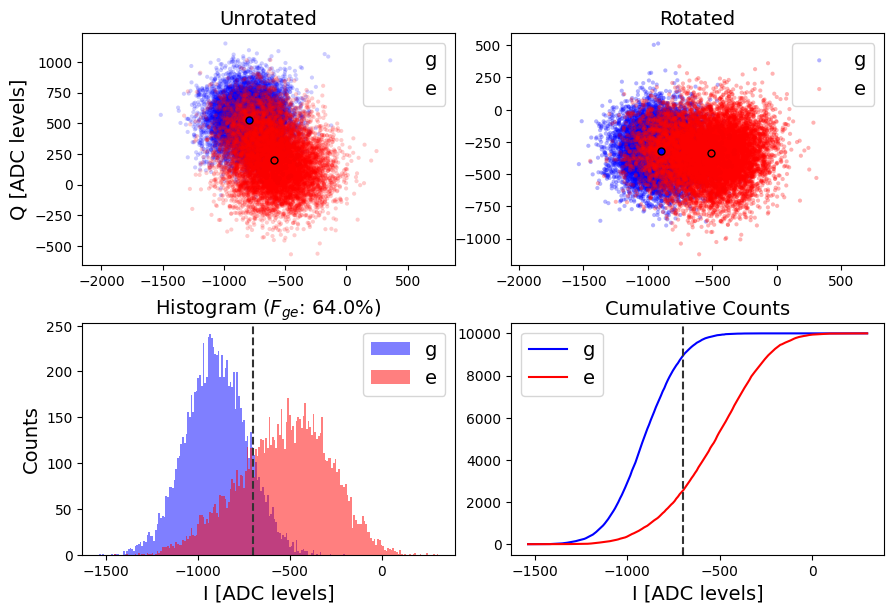

gf fidelity (%): 64.03999999999999
thresholds_f=[0, 0, -697.719746379322, 0],
angles_f=[0, 0, 52.747394153168315, 0],
gf_avgs=[array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), [-795.9829262001628, 523.9814758340115, -590.6201620829943, 214.219306997559], array([0., 0., 0., 0.])],
counts_calib_f=[[8845.0, 1155.0], [8832.0, 1168.0], [2465.0, 7535.0]]


  0%|          | 0/6 [00:00<?, ?it/s]

In [131]:
rbprog = meas.SimultaneousRBEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb1Q_qubit{qubit_i}",
    config_file=config_path,
)

gate_char = None
# gate_char = 'X'
ZZ_qubit = 0
# ZZ_qubit = None

# max_gates = 225
max_gates = 50

# max_gates = 150
# max_gates = 40
expts = 5

if gate_char is None: step = max_gates // expts
else: step = max_gates // (2*expts)
print('step', step)

rbprog.cfg.expt = dict(
    start=1, # rb depth start
    # start=200, # rb depth start
    step=step, # step rb depth
    # expts=1, # number steps
    expts=expts+1, # number steps
    reps=2000, # number averages per unique sequence
    reps_f=5000,
    loops=1,
    # reps=100, # number averages per unique sequence
    variations=5, # number different sequences per depth
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=[qubit_i], # the qubits to perform simultaneous RB on (if eg-gf, q should be qA != 1)
    ZZ_qubit=ZZ_qubit,
    # qubits=qubits,
    # qDrive=qubits[0],
    singleshot_reps=10000, # reps per state for singleshot calibration
    # singleshot_reps=100, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None
    measure_f=[qubit_i],

)

print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

In [106]:
rbprog.save_data()

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00002_rb1Q_qubit2.h5


'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00002_rb1Q_qubit2.h5'

counts calib total shape (1, 3, 4)
counts raw shape (1, 6, 5, 4) (loops, depths, variations, 4)
[ 159.  1841.  1733.2  266.8]


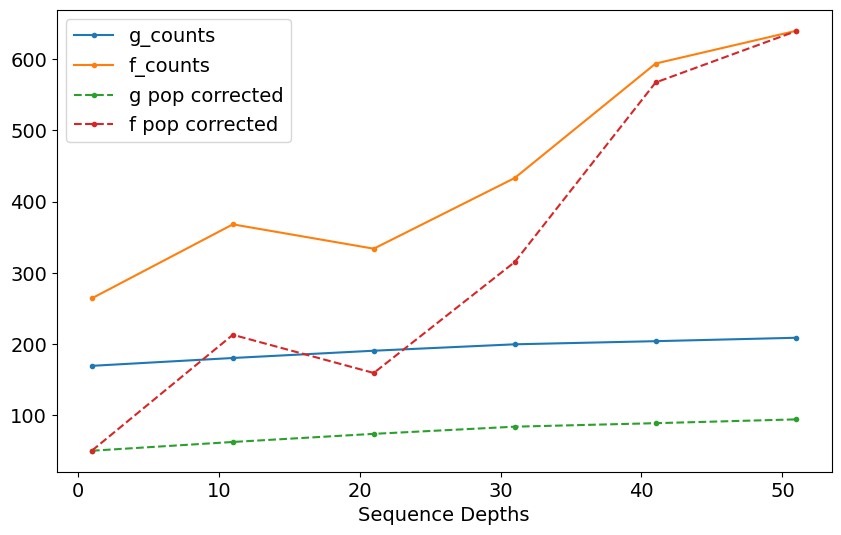

fit1 p1, a, offset [0.97632826 0.03278226 0.94298694]
fit2 a0, b0, c0, p2 [1.26922956e-14 1.82563023e-12 9.72066703e-01 9.92201106e-01]
Running regular RB on EF subspace
Depolarizing parameter p1 from fit: 0.9763282642528838 +/- 0.028624165951126764
Running regular RB on EF subspace
Depolarizing parameter p2 from fit: 0.9922011058824923 +/- 0.3693415657802845
Fidelity: 0.9954257539226962 +/- 0.0682078264066866
Leakage L1: 0.0013495980370999056
Seepage L2: 0.022322137710016322
Depolarizing parameter p from e/subspace fit: 0.9926739307414386 +/- 0.02787037852035907
Average RB gate error on e/subspace: 0.003663034629280748 +/- 0.013935189260179535
	Fidelity of e/subspace=1-error: 0.9963369653707193 +/- 0.013935189260179535


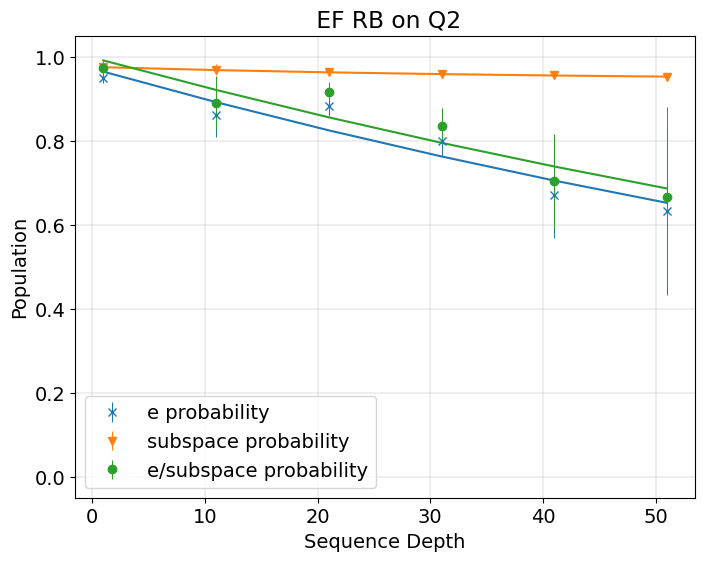

In [135]:
rbprog.analyze(fit=True, separate_correction=True)
rbprog.display(fit=True, show_all_vars=False)